<a href="https://colab.research.google.com/github/aguilarafa2010/DL_CIFAR10/blob/main/Deep_Learning_(b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/transfer-learning-in-tensorflow-9e4f7eae3bb4

https://towardsdatascience.com/transfer-learning-in-tensorflow-5d2b6ad495cb

In [ ]:
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout
from keras import regularizers
import keras
import skimage.transform

import matplotlib.pyplot as plt
import matplotlib.style as sty

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

import os
import random as rn
import tensorflow as tf
import seaborn as sns

In [ ]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()

	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [ ]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
print(trainX.shape)
print(testX.shape)



170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:

# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

In [ ]:
# Load VGG16 without the top FC Layers.
from keras.applications import VGG16
from keras.layers import Lambda, Input
from tensorflow.image import resize

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg_conv.summary()



58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# Fine Tunning VGG16 
# Create 'model' from vgg_conv adding dense layers and reducing the number of classes to 10
def define_model():
  
  model = Sequential()
  model.add(Input((32,32,3)))
  model.add(Lambda(lambda image: resize(image, (224, 224))))
  model.add(vgg_conv)
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))

  return model

In [ ]:
model = define_model()

In [ ]:
# Freeze the layers except the last 4 layers
for layer in model.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.layers.core.Lambda object at 0x7f1af1939290> False
<tensorflow.python.keras.engine.functional.Functional object at 0x7f1ae0476c50> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7f1ae041a1d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1ae047aed0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f1ae03e2ed0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1ae03d59d0> True


In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 40,416,074
Trainable params: 25,701,386
Non-trainable params: 14,714,688
___________________________________

In [ ]:
# Traning the model
print(trainX.shape)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(trainX, trainY, 
          batch_size=128,
          epochs=100,
          verbose=1,
          callbacks = [es],
          validation_split=0.2)

(50000, 32, 32, 3)
Epoch 1/100
313/313 [==============================] - 262s 675ms/step - loss: 2.5136 - accuracy: 0.3707 - val_loss: 1.1575 - val_accuracy: 0.6190
Epoch 2/100
313/313 [==============================] - 209s 670ms/step - loss: 1.2353 - accuracy: 0.5632 - val_loss: 0.9899 - val_accuracy: 0.6545
Epoch 3/100
313/313 [==============================] - 214s 683ms/step - loss: 1.1174 - accuracy: 0.6082 - val_loss: 0.9146 - val_accuracy: 0.6913
Epoch 4/100
313/313 [==============================] - 214s 684ms/step - loss: 1.0868 - accuracy: 0.6176 - val_loss: 0.9109 - val_accuracy: 0.6862
Epoch 5/100
313/313 [==============================] - 214s 684ms/step - loss: 1.0504 - accuracy: 0.6258 - val_loss: 0.8645 - val_accuracy: 0.7030
Epoch 6/100
313/313 [==============================] - 214s 685ms/step - loss: 1.0487 - accuracy: 0.6289 - val_loss: 0.8590 - val_accuracy: 0.7138
Epoch 7/100
313/313 [==============================] - 214s 685ms/step - loss: 1.0389 - accuracy: 0

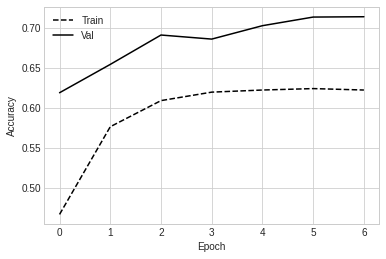

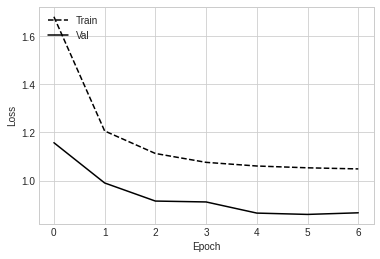

In [ ]:
# Plota o grafico do histórico de evolução da taxa de acertos da rede
sty.use('seaborn-whitegrid')
plt.plot(history.history['accuracy'],'k--')
plt.plot(history.history['val_accuracy'],'k')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


# Plota o grafico do histórico de evolução da taxa de perda da rede 
plt.plot(history.history['loss'],'k--')
plt.plot(history.history['val_loss'],'k')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# evaluate model
_, acc = model.evaluate(testX, testY, verbose=0)
print('Final Accuracy: > %.3f' % (acc * 100.0))

Final Accuracy: > 71.220


In [ ]:
# Data Augmentation

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)



In [ ]:
# Apply the generator
datagen.fit(trainX)



In [ ]:
# prepare iterator
it_train = datagen.flow(trainX, trainY, batch_size=128)



In [ ]:
# fit model
steps = int(trainX.shape[0] / 64)
history = model.fit_generator(it_train, 
                              epochs=100,
                              verbose=1,
                              callbacks = [es])


391/391 [==============================] - 214s 546ms/step - loss: 1.2495 - accuracy: 0.5452
Epoch 12/100
391/391 [==============================] - 214s 546ms/step - loss: 1.2385 - accuracy: 0.5525
Epoch 13/100
391/391 [==============================] - 214s 547ms/step - loss: 1.2404 - accuracy: 0.5523
Epoch 14/100
391/391 [==============================] - 214s 547ms/step - loss: 1.2146 - accuracy: 0.5601
Epoch 15/100
391/391 [==============================] - 214s 546ms/step - loss: 1.2206 - accuracy: 0.5537
Epoch 16/100
211/391 [===============>..............] - ETA: 1:38 - loss: 1.1989 - accuracy: 0.5652

KeyboardInterrupt: ignored

In [ ]:
# # Plota o grafico do histórico de evolução da taxa de acertos da rede
# sty.use('seaborn-whitegrid')
# plt.plot(history.history['accuracy'],'k--')
# plt.plot(history.history['val_accuracy'],'k')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()


# # Plota o grafico do histórico de evolução da taxa de perda da rede 
# plt.plot(history.history['loss'],'k--')
# plt.plot(history.history['val_loss'],'k')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

In [ ]:
# evaluate model
_, acc = model.evaluate(testX, testY, verbose=0)
print('Test Accuracy: > %.3f' % (acc * 100.0))

Test Accuracy: > 70.230


In [ ]:
y_predict = np.argmax(model.predict(testX), axis=-1)

In [ ]:
cm = confusion_matrix(np.argmax(testY,axis=1),y_predict)

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']

In [ ]:
#Função para realizar e plotar a matrix de confusão 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  
  print(cm)
  
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")
   
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(cm,cm_plot_labels,title ='Confusion Matrix')